<a id = "table_of_contents"></a>
# Índice
[Objetivos del notebook](#objetivos)

[Importación de las principales librerías](#import_modules)

[Importación de los datos](#import_data)

[Exploratory Data Analysis (EDA)](#eda)

---> [EDA customers df](#df1)

---> [EDA orders df](#df2)

---> [EDA payments df](#df3)

[Creación de variables](#fe)

[Join final con clientes y variables finales](#join)

[Creación de nuestro Pipeline](#skpipeline)

[Elbow curve](#elbow_curve)

[Segmentación de los clientes con la "k adecuada"](#segmentacion)

[Modelo RFM](#rfm)

[Ficha de clientes](#ficha)

[Conclusión](#conclusión)

<a id = "objetivos"></a>
# 0.Objetivos del notebook
[Volver al índice](#toc)

En este notebook vamos a trabajar con el dataset de la **compañia brasileña de E-Commerce llamada Olist.**

La compañia opera con una filosofía de ***SaaS (Software as a Service)***. Su producto básico es un marketplace donde tiendas **con o sin presencia online pueden vender sus productos a los clientes que visitan su web.**

![Data Model](https://i.imgur.com/HRhd2Y0.png)

Utilizando el dataset de Olist (alrededor de 100 mil registros) vamos a construir una segmentacion basada en el algoritmo KMeans. El enfoque a la hora de construir variables será basado en el modelo de ***RFM (recency - frequency - monetary value).*** Esta es una forma de trabajar muy común en startups y tiendas online donde se dispone de poca información de los clientes y la retención/canje de los clicks es fundamental.

Nuestros principales objetivos serán:
1. **Construir variables de negocio (pensadas para nuestra segmentación)** a partir de 3 datasets diferentes y juntarlos de forma correcta para no generar duplicidades de registros.



2. **Aprender a utilizar el Pipeline de sklearn** para agilizar mucho la transformación del dataset y la creación de variables.



3. **Aprender a implementar nuestros propios Transformers** que se puedan usar dentro de los Pipelines (por ejemplo para eliminar los outliers).



4. Usar el diagrama del codo para determinar la cantidad **"óptima"** de centroides para el modelo de KMeans.



5. **Resumir la información de nuestros clústers en un formato más amigable** usando Pandas (fichas de clientes).

<a id = "import_modules"></a>
# 1.Importación de las principales librerías
[Volver al índice](#table_of_contents)

In [2]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# python core library for machine learning and data science
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

RANDOM_STATE = 175

In [3]:
PATH_FOLDER = "C:\\Users\\Jordi Grau\\Desktop\\Data Science Project\\KMeans_Olist\\KMeans_Olist\\olist_datasets"

<a id = "import_data"></a>
# 2.Importación de los datos
[Volver al índice](#table_of_contents)

In [4]:
PATH_CUSTOMERS = (PATH_FOLDER + '\\olist_customers_dataset.csv')

customer_df = pd.read_csv(PATH_CUSTOMERS)


In [5]:
PATH_ORDERS = os.path.join(PATH_FOLDER + '\\olist_orders_dataset.csv')

orders_df = pd.read_csv(PATH_ORDERS)

In [6]:
PATH_PAYMENTS = os.path.join(PATH_FOLDER + '\\olist_order_payments_dataset.csv')

payments_df = pd.read_csv(PATH_PAYMENTS)

<a id = "eda"></a>
# 3.Exploratory Data Analysis (EDA)
[Volver al índice](#table_of_contents)

En la sección del EDA haremos **una primera aproximación a nuestros datos** para ver su composición y que variables tenemos a nuestra disposición.

<a id = "df1"></a>
## 3.1. EDA customers df
[Volver al índice](#table_of_contents)

EDA rápido sobre el **dataset de clientes.**

In [7]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos")

In [8]:
report_df(customer_df)

customer_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None

Tenemos un total de 0 nulos


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [9]:
customer_id = customer_df['customer_id'].nunique()
customer_unique_id = customer_df['customer_unique_id'].nunique()

print(f'''Tenemos un total de {customer_unique_id} clientes únicos, \n
para un total de {customer_id} pedidos (en el esquema de Olist, especifican que customer_unique_id es el
id del cliente y customer_id es un id que se genera en cada compra).
Esto implicat que el ratio de pedidos por cliente es de {round(customer_id/customer_unique_id, 2)}.
''')

Tenemos un total de 96096 clientes únicos, 

para un total de 99441 pedidos (en el esquema de Olist, especifican que customer_unique_id es el
id del cliente y customer_id es un id que se genera en cada compra).
Esto implicat que el ratio de pedidos por cliente es de 1.03.



In [10]:
# create a groupby Dataframe by customer_city
city_pivot_ = customer_df.groupby(['customer_state', 'customer_city']).size()\
.sort_values(ascending = False).to_frame().reset_index().rename(columns = {0:"clients_per_city"})

city_pivot_['cumsum_per_city'] = (city_pivot_['clients_per_city']/city_pivot_['clients_per_city'].sum()).cumsum()
city_pivot_['pct_city'] = (1/city_pivot_.shape[0])
city_pivot_['pct_city'] = city_pivot_['pct_city'].cumsum()

In [11]:
# create a groupby Dataframe by customer_state
state_pivot_ = customer_df.groupby('customer_state').size()\
.sort_values(ascending = False).to_frame().reset_index().rename(columns = {0:"clients_per_state"})

state_pivot_['cumsum_per_state'] = (state_pivot_['clients_per_state']/state_pivot_['clients_per_state'].sum()).cumsum()

state_pivot_['pct_state'] = (1/state_pivot_.shape[0])
state_pivot_['pct_state'] = state_pivot_['pct_state'].cumsum()

Text(0.5, 0.98, 'Distribución acumulada de clientes por ciudad y estado (en absoluto y relativo)')

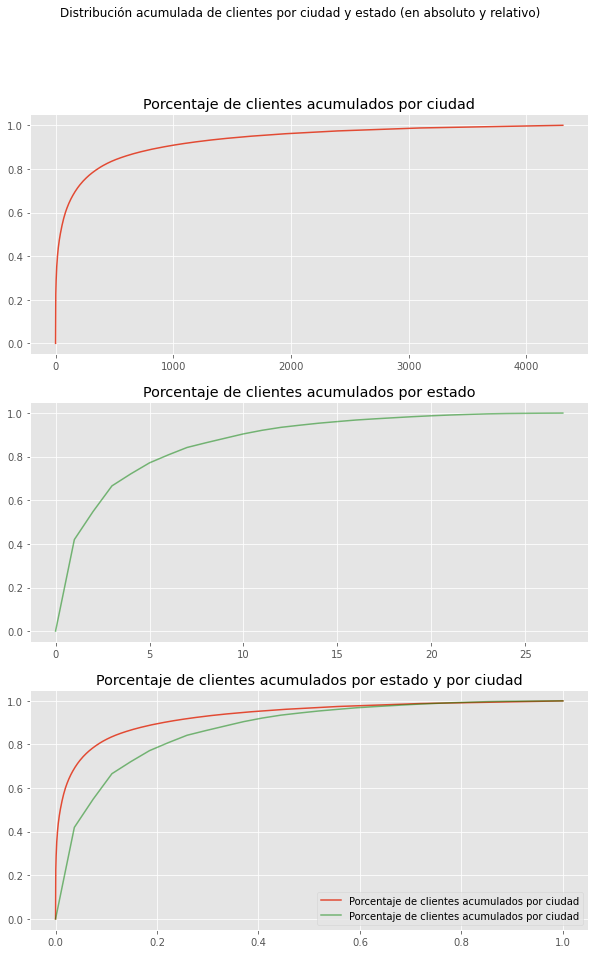

In [12]:
# Ploting part

# instanciate the figure
fig = plt.figure(figsize=(10, 15))
ax1, ax2, ax3 = fig.subplots(nrows = 3, ncols = 1)

x1_values = [0] + list(city_pivot_.index)
y1_values = [0] + list(city_pivot_["cumsum_per_city"])

x2_values = [0] + list(state_pivot_["cumsum_per_state"])
y2_values = [0] + list(state_pivot_["cumsum_per_state"])

x3_values_city = [0] + list(city_pivot_["pct_city"])
y3_values_city = [0] + list(city_pivot_["cumsum_per_city"])

x3_values_state = [0] + list(state_pivot_["pct_state"])
y3_values_state = [0] + list(state_pivot_["cumsum_per_state"])

# plot the values and set for every subplot a title
ax1.plot(y1_values)
ax1.title.set_text("Porcentaje de clientes acumulados por ciudad")

ax2.plot(y2_values, color = 'green', alpha = 0.5)
ax2.title.set_text("Porcentaje de clientes acumulados por estado")

ax3.plot(x3_values_city, y3_values_city, label = 'Porcentaje de clientes acumulados por ciudad')
ax3.plot(x3_values_state, y3_values_state, label = 'Porcentaje de clientes acumulados por ciudad',
        color = 'green', alpha = 0.5)
ax3.title.set_text('Porcentaje de clientes acumulados por estado y por ciudad')

ax3.legend()

# create a title for the subplots
fig.suptitle('Distribución acumulada de clientes por ciudad y estado (en absoluto y relativo)')

<a id = "df2"></a>
## 3.2. EDA orders df
[Volver al índice](#table_of_contents)

EDA rápido sobre el **dataset de pedidos.**

In [13]:
report_df(orders_df)

orders_df.head(3).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None

Tenemos un total de 4908 nulos


,0,1,2
order_id,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d
customer_id,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089
order_status,delivered,delivered,delivered
order_purchase_timestamp,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49
order_approved_at,2017-10-02 11:07:15,2018-07-26 03:24:27,2018-08-08 08:55:23
order_delivered_carrier_date,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00
order_delivered_customer_date,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29
order_estimated_delivery_date,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00


In [14]:
orders_df["order_status"].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [15]:
# tenemos nulls en las fechas, habrá o bien eliminar estos nulos o imputarles una fecha.
orders_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [16]:
order_id = orders_df['order_id'].nunique()
customer_id_orders = orders_df['customer_id'].nunique()

# nos aseguramos que todos los orders tiene su correspondiente cliente en la tabla de customers
assert (set(orders_df["customer_id"]) ^ set(customer_df["customer_id"])) == set()
assert (set(customer_df["customer_id"]) ^ set(orders_df["customer_id"])) == set()

print(f"Tenemos un total de {order_id} pedidos")
print(f"Tenemos un total de {customer_unique_id} customer únicos (de la tabla de customers)")
print(f"La relación de pedidos por clientes es de {round(order_id/customer_unique_id, 2)}")

Tenemos un total de 99441 pedidos
Tenemos un total de 96096 customer únicos (de la tabla de customers)
La relación de pedidos por clientes es de 1.03


<a id = "df3"></a>
## 3.3. EDA payments df
[Volver al índice](#table_of_contents)

EDA rápido sobre el **dataset de pagos.**

In [17]:
report_df(payments_df)

payments_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
None

Tenemos un total de 0 nulos


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


<AxesSubplot:>

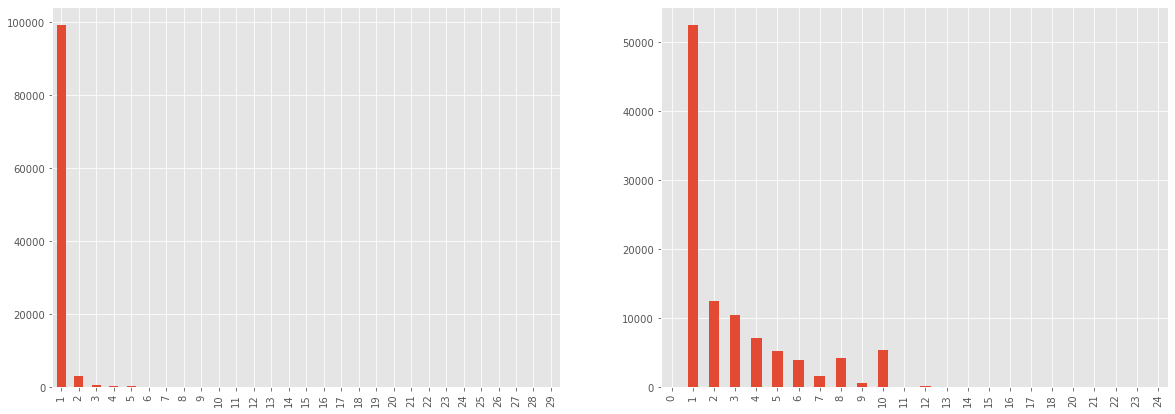

In [18]:
fig = plt.figure(figsize=(20, 7))
ax1, ax2 = fig.subplots(1, 2)

payments_df['payment_sequential'].value_counts().sort_index().plot(kind = 'bar', ax = ax1)
payments_df['payment_installments'].value_counts().sort_index().plot(kind = 'bar', ax = ax2)

In [19]:
payments_df['payment_sequential'].value_counts()

1     99360
2      3039
3       581
4       278
5       170
6       118
7        82
8        54
9        43
10       34
11       29
12       21
13       13
14       10
15        8
18        6
19        6
16        6
17        6
21        4
20        4
22        3
26        2
24        2
23        2
25        2
29        1
28        1
27        1
Name: payment_sequential, dtype: int64

In [20]:
order_id_pay = payments_df['order_id'].nunique()
print(f'Tenemos un total de {order_id_pay} pedidos únicos en la tabla de payments')

Tenemos un total de 99440 pedidos únicos en la tabla de payments


In [21]:
# nos aseguramos que todos los orders tiene su correspondiente cliente en la tabla de customers
len(set(orders_df["order_id"]))

99441

In [22]:
set(orders_df["order_id"]) ^ set(payments_df["order_id"])

{'bfbd0f9bdef84302105ad712db648a6c'}

In [23]:
orders_df[orders_df["order_id"] == "bfbd0f9bdef84302105ad712db648a6c"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00


In [24]:
payments_df['order_id'].value_counts()

fa65dad1b0e818e3ccc5cb0e39231352    29
ccf804e764ed5650cd8759557269dc13    26
285c2e15bebd4ac83635ccc563dc71f4    22
895ab968e7bb0d5659d16cd74cd1650c    21
fedcd9f7ccdc8cba3a18defedd1a5547    19
                                    ..
6d2a30c9b7dcee3ed507dc9a601f99e7     1
a7737f6d9208dd56ea498a322ed3c37f     1
646e62df54f3e236eb6d5ff3b31429b8     1
e115da7a49ec2acf622e1f31da65cfb9     1
28bbae6599b09d39ca406b747b6632b1     1
Name: order_id, Length: 99440, dtype: int64

In [25]:
order_id_ = 'fa65dad1b0e818e3ccc5cb0e39231352'

In [26]:
payments_df.groupby('order_id').get_group((order_id_)).sort_values(by='payment_sequential')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71
23074,fa65dad1b0e818e3ccc5cb0e39231352,2,voucher,1,8.51
65641,fa65dad1b0e818e3ccc5cb0e39231352,3,voucher,1,2.95
9985,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16
28330,fa65dad1b0e818e3ccc5cb0e39231352,5,voucher,1,0.66
29648,fa65dad1b0e818e3ccc5cb0e39231352,6,voucher,1,5.02
82593,fa65dad1b0e818e3ccc5cb0e39231352,7,voucher,1,0.32
68853,fa65dad1b0e818e3ccc5cb0e39231352,8,voucher,1,26.02
17274,fa65dad1b0e818e3ccc5cb0e39231352,9,voucher,1,1.08
19565,fa65dad1b0e818e3ccc5cb0e39231352,10,voucher,1,12.86


<a id = "fe"></a>
# 4.Creación de variables
[Volver al índice](#table_of_contents)

Hemos analizado los 3 datasets claves con los que vamos a trabajar.

En esta sección del notebook, **iremos agregando el dataset y vamos a generar nuevas variables** para que después en la siguiente sección lo juntamos en uno y hacemos la segmentación.

In [27]:
# hacemos un groupby por order y calculamos algunas métricas básicas como max, min, media y similares.
# Hemos visto que gran parte de los pagos son únicos, por tanto coincidirán en la mayoría, pero en los demás casos
# nos van a aportar información útil sobre el cliente.

aggregated_payments = payments_df.groupby('order_id').agg(
    max_pay = ('payment_value', 'max'), 
    min_pay = ('payment_value', 'min'),
    mean_pay = ('payment_value', 'mean'),
    total_pay = ('payment_value', 'sum'),
    max_seq = ('payment_sequential', 'max')
)

In [28]:
aggregated_payments.loc[order_id_]

max_pay      150.000000
min_pay        0.000000
mean_pay      15.792759
total_pay    457.990000
max_seq       29.000000
Name: fa65dad1b0e818e3ccc5cb0e39231352, dtype: float64

In [29]:
aggregated_payments[aggregated_payments["max_seq"] == 3]

,max_pay,min_pay,mean_pay,total_pay,max_seq
order_id,,,,,
00bd50cdd31bd22e9081e6e2d5b3577b,40.46,4.88,28.600000,85.80,3
039f61edec89c6f0edf8dd1a0bdea1fe,166.22,50.00,105.406667,316.22,3
03e5d6a8dd520898f86f8429ccd07c21,46.80,42.24,45.280000,135.84,3
06875ab72c5b9bb2eb303a70031bfeb0,22.68,2.32,15.893333,47.68,3
070d6fe21e7d454b11f1cb27ca2c15c0,89.46,4.78,39.410000,118.23,3
...,...,...,...,...,...
fb260abf14e47c95a0b19acb1ab3ed43,20.00,0.94,11.666667,35.00,3
fd2b75f431649ee3de573b444d320f48,49.02,25.00,33.006667,99.02,3
fd513fb508fefbe0ce7bfb8fd1bee4fc,66.49,3.54,24.690000,74.07,3


In [31]:
payments_df.shape

(103886, 5)

In [32]:
aggregated_payments.shape

(99440, 5)

In [33]:
orders_df.shape

(99441, 8)

In [34]:
orders_with_payments = pd.merge(orders_df, aggregated_payments, on = 'order_id')

In [35]:
orders_with_payments.shape

(99440, 13)

In [36]:
report_df(orders_with_payments)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99440 entries, 0 to 99439
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99440 non-null  object 
 1   customer_id                    99440 non-null  object 
 2   order_status                   99440 non-null  object 
 3   order_purchase_timestamp       99440 non-null  object 
 4   order_approved_at              99280 non-null  object 
 5   order_delivered_carrier_date   97657 non-null  object 
 6   order_delivered_customer_date  96475 non-null  object 
 7   order_estimated_delivery_date  99440 non-null  object 
 8   max_pay                        99440 non-null  float64
 9   min_pay                        99440 non-null  float64
 10  mean_pay                       99440 non-null  float64
 11  total_pay                      99440 non-null  float64
 12  max_seq                        99440 non-null 

In [37]:
orders_with_payments.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,max_pay,min_pay,mean_pay,total_pay,max_seq
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,18.59,2.00,12.903333,38.71,3
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,141.46,141.46,141.460000,141.46,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,179.12,179.12,179.120000,179.12,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,72.20,72.20,72.200000,72.20,1
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,28.62,28.62,28.620000,28.62,1


In [38]:
#orders_with_payments["order_id_back"] = orders_with_payments["order_id"]
orders_with_payments.set_index('order_id', inplace = True)

In [39]:
# convertimos las fechas al formato fechas dado que hasta ahora eran object y no nos permitían hacer
# casi ninguna transformación

orders_with_payments['order_purchase_timestamp'] =\
pd.to_datetime(orders_with_payments['order_purchase_timestamp'], format = '%Y-%m-%d')

orders_with_payments['order_delivered_customer_date'] =\
pd.to_datetime(orders_with_payments['order_delivered_customer_date'], format = '%Y-%m-%d')

In [40]:
report_df(orders_with_payments)

<class 'pandas.core.frame.DataFrame'>
Index: 99440 entries, e481f51cbdc54678b7cc49136f2d6af7 to 66dea50a8b16d9b4dee7af250b4be1a5
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    99440 non-null  object        
 1   order_status                   99440 non-null  object        
 2   order_purchase_timestamp       99440 non-null  datetime64[ns]
 3   order_approved_at              99280 non-null  object        
 4   order_delivered_carrier_date   97657 non-null  object        
 5   order_delivered_customer_date  96475 non-null  datetime64[ns]
 6   order_estimated_delivery_date  99440 non-null  object        
 7   max_pay                        99440 non-null  float64       
 8   min_pay                        99440 non-null  float64       
 9   mean_pay                       99440 non-null  float64       
 10  total_pay                    

In [41]:
orders_with_payments['order_estimated_delivery_date'] =\
pd.to_datetime(orders_with_payments['order_estimated_delivery_date'], format = '%Y-%m-%d')

In [42]:
report_df(orders_with_payments)

<class 'pandas.core.frame.DataFrame'>
Index: 99440 entries, e481f51cbdc54678b7cc49136f2d6af7 to 66dea50a8b16d9b4dee7af250b4be1a5
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    99440 non-null  object        
 1   order_status                   99440 non-null  object        
 2   order_purchase_timestamp       99440 non-null  datetime64[ns]
 3   order_approved_at              99280 non-null  object        
 4   order_delivered_carrier_date   97657 non-null  object        
 5   order_delivered_customer_date  96475 non-null  datetime64[ns]
 6   order_estimated_delivery_date  99440 non-null  datetime64[ns]
 7   max_pay                        99440 non-null  float64       
 8   min_pay                        99440 non-null  float64       
 9   mean_pay                       99440 non-null  float64       
 10  total_pay                    

In [43]:
# creamos variables útiles extrayendo la información de los pedidos.
# Por ejemplo: tiempo desde la última compra puede ser muy útil para que nuestro modelo detecte clientes
# recientes y combinando con la variable de pedidos totales podrá ser muy valiosas para segmentar a los clientes
# muy fidelizados.

orders_with_payments['last_purchase'] = orders_with_payments['order_purchase_timestamp'].max()

orders_with_payments['time_since_last_purchase'] =\
orders_with_payments['last_purchase'] - orders_with_payments['order_purchase_timestamp']

orders_with_payments['delivery_time'] =\
orders_with_payments['order_delivered_customer_date'] - orders_with_payments['order_purchase_timestamp']

orders_with_payments['delay'] =\
orders_with_payments['order_delivered_customer_date'] - orders_with_payments['order_estimated_delivery_date']

In [44]:
orders_with_payments.head().T

order_id,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d,949d5b44dbf5de918fe9c16f97b45f8a,ad21c59c0840e6cb83a9ceb5573f8159
customer_id,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089,f88197465ea7920adcdbec7375364d82,8ab97904e6daea8866dbdbc4fb7aad2c
order_status,delivered,delivered,delivered,delivered,delivered
order_purchase_timestamp,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49,2017-11-18 19:28:06,2018-02-13 21:18:39
order_approved_at,2017-10-02 11:07:15,2018-07-26 03:24:27,2018-08-08 08:55:23,2017-11-18 19:45:59,2018-02-13 22:20:29
order_delivered_carrier_date,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00,2017-11-22 13:39:59,2018-02-14 19:46:34
order_delivered_customer_date,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29,2017-12-02 00:28:42,2018-02-16 18:17:02
order_estimated_delivery_date,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00,2017-12-15 00:00:00,2018-02-26 00:00:00
max_pay,18.59,141.46,179.12,72.2,28.62
min_pay,2.0,141.46,179.12,72.2,28.62
mean_pay,12.903333,141.46,179.12,72.2,28.62


<a id = "join"></a>
# 5.Join final con clientes y variables finales
[Volver al índice](#table_of_contents)

In [45]:
df_final = pd.merge(customer_df, orders_with_payments, on = "customer_id")

In [46]:
#df_final.set_index("order_id_back", inplace = True)
df_final.set_index("customer_unique_id", inplace = True)

lc = [
    'max_pay',
    'min_pay',
    'mean_pay',
    'total_pay',
    'max_seq',
    'time_since_last_purchase',
    'delivery_time',
    'delay'
]

df_final = df_final[lc]

# extraemos los días de la variable timedelta que teníamos calculada previamente.
df_final["time_since_last_purchase"] = df_final["time_since_last_purchase"].dt.days
df_final["delivery_time"] = df_final["delivery_time"].dt.days
df_final["delay"] = df_final["delay"].dt.days

In [47]:
df_final.head().T

customer_unique_id,861eff4711a542e4b93843c6dd7febb0,290c77bc529b7ac935b93aa66c333dc3,060e732b5b29e8181a18229c7b0b2b5e,259dac757896d24d7702b9acbbff3f3c,345ecd01c38d18a9036ed96c73b8d066
max_pay,146.87,335.48,157.73,173.3,252.25
min_pay,146.87,335.48,157.73,173.3,252.25
mean_pay,146.87,335.48,157.73,173.3,252.25
total_pay,146.87,335.48,157.73,173.3,252.25
max_seq,1.00,1.00,1.00,1.0,1.00
time_since_last_purchase,519.00,277.00,151.00,218.0,80.00
delivery_time,8.00,16.00,26.00,14.0,11.00
delay,-11.00,-8.00,1.00,-13.0,-6.00


In [49]:
report_df(df_final)

df_final.sample(3).T

<class 'pandas.core.frame.DataFrame'>
Index: 99440 entries, 861eff4711a542e4b93843c6dd7febb0 to 84732c5050c01db9b23e19ba39899398
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   max_pay                   99440 non-null  float64
 1   min_pay                   99440 non-null  float64
 2   mean_pay                  99440 non-null  float64
 3   total_pay                 99440 non-null  float64
 4   max_seq                   99440 non-null  int64  
 5   time_since_last_purchase  99440 non-null  int64  
 6   delivery_time             96475 non-null  float64
 7   delay                     96475 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 6.8+ MB
None

Tenemos un total de 5930 nulos


customer_unique_id,c2ff93aae333fdc4b28c3862fb21d909,b68cae0c0000896cd8aa71e534d377a8,02238d275f51bce58c8e97218621bd91
max_pay,325.37,102.97,36.0
min_pay,325.37,102.97,36.0
mean_pay,325.37,102.97,36.0
total_pay,325.37,102.97,36.0
max_seq,1.00,1.00,1.0
time_since_last_purchase,110.00,218.00,276.0
delivery_time,14.00,2.00,9.0
delay,-23.00,-14.00,-16.0


In [51]:
# tenemos valores nulos y habrá que imputarlas de forma correcta en nuestro pipeline.
df_final.isnull().sum()

max_pay                        0
min_pay                        0
mean_pay                       0
total_pay                      0
max_seq                        0
time_since_last_purchase       0
delivery_time               2965
delay                       2965
dtype: int64

In [52]:
outlier = np.percentile(payments_df['payment_value'], q = 95)

In [53]:
payments_df[payments_df['payment_value'] < outlier].shape

(98691, 5)

In [55]:
def mean_with_no_outliers(series):
  outlier = np.percentile(series, q = 95)
  series_no_outlier = series[series < outlier]
  return np.mean(series_no_outlier)

In [56]:
pay_ = payments_df[payments_df['order_id'] == order_id_]

In [57]:
mean_with_no_outliers(pay_['payment_value'])

8.96185185185185

In [58]:
pay_.groupby('order_id').agg(
    max_pay = ('payment_value', 'max'),
    custom_func = ('payment_value', mean_with_no_outliers)
)

,max_pay,custom_func
order_id,,
fa65dad1b0e818e3ccc5cb0e39231352,150.0,8.961852


In [59]:
# 1-->  Hacer algo con los nulos
# 2--> Convertir de numpy array a pandas dataframe
# 3--> Hacer un groupby por customer_id
# 4--> Quitar outliers
# 5--> Standarizar

In [60]:
order_id_

'fa65dad1b0e818e3ccc5cb0e39231352'

In [61]:
payments_df[payments_df['order_id']==order_id_]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
4885,fa65dad1b0e818e3ccc5cb0e39231352,27,voucher,1,66.02
9985,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71
17274,fa65dad1b0e818e3ccc5cb0e39231352,9,voucher,1,1.08
19565,fa65dad1b0e818e3ccc5cb0e39231352,10,voucher,1,12.86
23074,fa65dad1b0e818e3ccc5cb0e39231352,2,voucher,1,8.51
24879,fa65dad1b0e818e3ccc5cb0e39231352,25,voucher,1,3.68
28330,fa65dad1b0e818e3ccc5cb0e39231352,5,voucher,1,0.66
29648,fa65dad1b0e818e3ccc5cb0e39231352,6,voucher,1,5.02
32519,fa65dad1b0e818e3ccc5cb0e39231352,11,voucher,1,4.03


In [62]:
imputer = SimpleImputer(strategy = 'mean')

In [67]:
imputer.fit(df_final)

SimpleImputer()

In [68]:
# fit sobre el train, transform sobre el test
array_imputed = imputer.transform(df_final)

In [69]:
scaler = StandardScaler()

In [70]:
scaler.fit_transform(array_imputed)

array([[-5.71941489e-02, -4.71791767e-02, -5.22274522e-02, ...,
         1.49098347e+00, -4.35155582e-01,  8.74776827e-02],
       [ 7.98690248e-01,  8.13903109e-01,  8.08245354e-01, ...,
        -8.39219219e-02,  4.15245315e-01,  3.86588420e-01],
       [-7.91306865e-03,  2.40119349e-03, -2.68217531e-03, ...,
        -9.03913988e-01,  1.47824644e+00,  1.28392063e+00],
       ...,
       [-4.69367309e-01, -4.61855514e-01, -4.66610279e-01, ...,
        -6.43599046e-01,  1.90344688e+00,  1.88214210e+00],
       [ 2.50306234e+00,  2.52862606e+00,  2.52175461e+00, ...,
         3.71629226e-01, -9.95513359e-03, -7.10150949e-01],
       [-6.24879521e-01, -6.18312171e-01, -6.22956194e-01, ...,
         7.87749165e-02, -5.41455694e-01, -1.11929475e-01]])

In [71]:
def array_to_df(array, df):
  df_fromarray = pd.DataFrame(array, columns = df.columns, index = df.index)
  return df_fromarray

In [72]:
array_to_df(array_imputed, df_final)

,max_pay,min_pay,mean_pay,total_pay,max_seq,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,146.87,146.87,146.87,146.87,1.0,519.0,8.0,-11.0
290c77bc529b7ac935b93aa66c333dc3,335.48,335.48,335.48,335.48,1.0,277.0,16.0,-8.0
060e732b5b29e8181a18229c7b0b2b5e,157.73,157.73,157.73,157.73,1.0,151.0,26.0,1.0
259dac757896d24d7702b9acbbff3f3c,173.30,173.30,173.30,173.30,1.0,218.0,14.0,-13.0
345ecd01c38d18a9036ed96c73b8d066,252.25,252.25,252.25,252.25,1.0,80.0,11.0,-6.0
...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,88.78,88.78,88.78,88.78,1.0,193.0,6.0,-12.0
d52a67c98be1cf6a5c84435bd38d095d,129.06,129.06,129.06,129.06,1.0,196.0,7.0,-9.0
e9f50caf99f032f0bf3c55141f019d99,56.04,56.04,56.04,56.04,1.0,191.0,30.0,7.0


In [73]:
class ArrayToDataFrame(BaseEstimator, TransformerMixin):

  def __init__(self, df):
    self.df = df
  
  def fit(self, X):
    return self

  def transform(self, X):

    df_fromarray = pd.DataFrame(
        data = X, 
        columns = self.df.columns, 
        index = self.df.index
    )

    return df_fromarray

In [74]:
ArrayToDataFrame(df = df_final).fit_transform(X = array_imputed)

,max_pay,min_pay,mean_pay,total_pay,max_seq,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,146.87,146.87,146.87,146.87,1.0,519.0,8.0,-11.0
290c77bc529b7ac935b93aa66c333dc3,335.48,335.48,335.48,335.48,1.0,277.0,16.0,-8.0
060e732b5b29e8181a18229c7b0b2b5e,157.73,157.73,157.73,157.73,1.0,151.0,26.0,1.0
259dac757896d24d7702b9acbbff3f3c,173.30,173.30,173.30,173.30,1.0,218.0,14.0,-13.0
345ecd01c38d18a9036ed96c73b8d066,252.25,252.25,252.25,252.25,1.0,80.0,11.0,-6.0
...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,88.78,88.78,88.78,88.78,1.0,193.0,6.0,-12.0
d52a67c98be1cf6a5c84435bd38d095d,129.06,129.06,129.06,129.06,1.0,196.0,7.0,-9.0
e9f50caf99f032f0bf3c55141f019d99,56.04,56.04,56.04,56.04,1.0,191.0,30.0,7.0


In [75]:
pipe = Pipeline(steps = [
    ('impute', SimpleImputer()),
    ('standarize', StandardScaler()),
    ('ArrayToDataFrame', ArrayToDataFrame(df = df_final))
])

pipe.fit_transform(df_final) # nailed it

,max_pay,min_pay,mean_pay,total_pay,max_seq,time_since_last_purchase,delivery_time,delay
customer_unique_id,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,-0.057194,-0.047179,-0.052227,-0.063619,-0.119094,1.490983,-0.435156,0.087478
290c77bc529b7ac935b93aa66c333dc3,0.798690,0.813903,0.808245,0.786166,-0.119094,-0.083922,0.415245,0.386588
060e732b5b29e8181a18229c7b0b2b5e,-0.007913,0.002401,-0.002682,-0.014689,-0.119094,-0.903914,1.478246,1.283921
259dac757896d24d7702b9acbbff3f3c,0.062741,0.073485,0.068351,0.055462,-0.119094,-0.467886,0.202645,-0.111929
345ecd01c38d18a9036ed96c73b8d066,0.421005,0.433924,0.428535,0.411172,-0.119094,-1.365973,-0.116255,0.585996
...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,-0.320798,-0.312384,-0.317244,-0.325345,-0.119094,-0.630583,-0.647756,-0.012226
d52a67c98be1cf6a5c84435bd38d095d,-0.138013,-0.128489,-0.133480,-0.143862,-0.119094,-0.611060,-0.541456,0.286885
e9f50caf99f032f0bf3c55141f019d99,-0.469367,-0.461856,-0.466610,-0.472855,-0.119094,-0.643599,1.903447,1.882142


In [76]:
df_final['delay'].fillna(df_final['delay'].mean())
df_final['delivery_time'].fillna(df_final['delivery_time'].mean())

customer_unique_id
861eff4711a542e4b93843c6dd7febb0     8.0
290c77bc529b7ac935b93aa66c333dc3    16.0
060e732b5b29e8181a18229c7b0b2b5e    26.0
259dac757896d24d7702b9acbbff3f3c    14.0
345ecd01c38d18a9036ed96c73b8d066    11.0
                                    ... 
1a29b476fee25c95fbafc67c5ac95cf8     6.0
d52a67c98be1cf6a5c84435bd38d095d     7.0
e9f50caf99f032f0bf3c55141f019d99    30.0
73c2643a0a458b49f58cea58833b192e    12.0
84732c5050c01db9b23e19ba39899398     7.0
Name: delivery_time, Length: 99440, dtype: float64

In [77]:
df_final.isnull().sum()

max_pay                        0
min_pay                        0
mean_pay                       0
total_pay                      0
max_seq                        0
time_since_last_purchase       0
delivery_time               2965
delay                       2965
dtype: int64

<a id = "skpipeline"></a>
# 6.Creación de nuestro Pipeline
[Volver al índice](#table_of_contents)

Llegamos a este punto tenemos que hacer las últimas transformaciones de nuestro dataframe así como crear las últimas variables para el **modelo RFM.**

Una forma de hacerlo es utilizar el pipeline de sklearn para automatizar todos estos pasos. Para ello tendremos que implementar nuestros propios ***"Transformers."***

Un ***Transformer*** en sklearn no es más una clase que tiene implementado el método **fit, transform  y fit_transform** (que puede realizar cualquier transformación sobre el dataset que le pasas).

No obstante, en la práctica sólo vamos a implementar un método, el **transform**, porque el **fit** (cuando heredamos de ***TransformerMixin***) sólo tiene que devolver el ***self*** y el **fit_transform** se va a crear sólo.

Heredamos también del ***BaseEstimator*** para tener acceso al método de ***get_params() y set_params()*** aunque en la práctica no lo vamos a usar.

In [78]:
class ArrayToDataFrame(BaseEstimator, TransformerMixin):
    '''
    Clase que transforma un array en un DataFrame.
    Necesita como parámetros el nombre de las columnas y el índice.
    '''
    
    def __init__(self, columns, index = None):
        self.columns = columns
        self.index = index
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        if self.index != None:
            df = pd.DataFrame(X, columns = self.columns, index = self.index)
            
        else:
            df = pd.DataFrame(X, columns = self.columns)
            
        return df

In [79]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    '''
    Clase que realiza unas transformaciones en el Pipeline.
    El dataset que le pasas debe ser un DataFrame válido.
    '''
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        aggregated_df = X.groupby(X.index).agg(
            n_orders = ('total_pay', 'count'),
            amount = ('total_pay', 'sum'),
            avg_ticket = ('total_pay', 'mean'),
            
            last_purchase = ('time_since_last_purchase', 'min'),
            first_purchase = ('time_since_last_purchase', 'max'),
            
            mean_delivery_time = ('delivery_time', 'mean'),
            max_delivery_time = ('delivery_time', 'max'),
            
            mean_delay = ('delay', 'mean'),
            max_delay = ('delay', 'max')
        )
        
        return aggregated_df

In [80]:
class OutlierFilter(BaseEstimator, TransformerMixin):
    '''
    Clase que filtra los outliers utilizando np.quantile()
    Los cuantiles a filtrar así como las columnas a filtrar son los parámetros de la clase.
    '''
    
    def __init__(self, q, col_to_filter):
        self.q = q
        self.col_to_filter = col_to_filter
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        '''
        El método considera outlier a aquel cliente que es outlier en todas las columnas que le pasas.
        Es decir: si tiene que filtrar importe y número de pedidos, sólo va a eliminar aquellos clientes
        que son outlier tanto en importe como número de pedidos. Si eres outlier en importe pero no en pedido
        no se te va a filtrar del dataset.
        '''
        
        # lista vacía
        criteria_list = []
        
        # agregamos a la lista los clientes que son outliers
        for col in self.col_to_filter:
            criteria = X[col] < np.quantile(X[col], q = self.q)
            criteria_list.append(criteria)
            
        # si hay más de 1 columna
        if len(self.col_to_filter) > 1:
            
            # creamos el criterio global: es decir outlier en todas las columnas
            global_criteria = criteria_list[0]
            
            for criteria in criteria_list[1:]:
                global_criteria = global_criteria & criteria
                
        else:
            global_criteria = criteria_list[0]
            
        # filtramos nuestra dataframe
        X = X[global_criteria]
        
        # guardamos el índice como parámetro de la clase porque en caso contrario lo perderíamos.
        self.index = X.index
        
        return X

In [83]:
df_back = df_final.copy(deep = True)

In [84]:
df_final.shape

(99440, 8)

In [85]:
# df_final = df_back.sample(15000)
df_final = df_back.copy(deep = True)
columns = list(df_final.columns)
index = list(df_final.index)

Llegamos a este punto tenemos todo listo para construir nuestro pipeline.

Los pasos que va a realizar son:

1. Usar el ***KNNImputer***, que se basa en la misma noción de **métricas de distancia** para imputar los valores nulos en función de los cliente más similares.

2. Dado que en el primer paso, nos devuelve un array, usamos nuestro propio ***Transformer*** para convertir a DataFrame.

3. Creamos variables a nivel de cliente. **POR TANTO VAMOS NUESTRO DATAFRAME DE SALIDA SERÁ MÁS PEQUEÑO.**

4. Filtramos los outliers con nuestro propio ***Transformer***. **POR TANTO VAMOS NUESTRO DATAFRAME DE SALIDA SERÁ MÁS PEQUEÑO.**

5. Estandarizamos los valores, usando ***StandardScaler***.

6. Hacemos un fit con KMeans para calcular la **inertia** de los grupos (la dispersión de los datos al centroide).

Técnica del ***Elbow Curve***: todo esto lo hacemos en una loop porque queremos ver cuando hay un cambio brusco en la inertia y por tanto, **aumentar más el número de centroides no nos sale a cuenta porque la ganacia marginal es muy pequeña.**

In [86]:
CALCULATE_ELBOW = True

In [87]:
# separamos el pipeline del a loop, para no tener que volver a hacer los primeros 5 pasos para cada k de la loop
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()),
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
    ("FeatureGenerator", FeatureGenerator()),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["amount", "max_delay"])),
    ("StandardScaler", StandardScaler())
])

In [88]:
df_scaled_transformed_no_outliers = pipe.fit_transform(df_final)

In [89]:
if CALCULATE_ELBOW:
    st = time.time()

    sse = {}

    for k in range(2, 15):

        print(f"Fitting pipe with {k} clusters")

        clustering_model = KMeans(n_clusters = k)

        clustering_model.fit(df_scaled_transformed_no_outliers)

        sse[k] = clustering_model.inertia_

    et = time.time()
    print("Elbow curve took {} minutes.".format(round((et - st)/60), 2))

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters
Elbow curve took 1 minutes.


In [90]:
sse

{2: 681595.6108279643,
 3: 558814.5177219087,
 4: 459467.7078994574,
 5: 387247.70816713833,
 6: 345076.1756381392,
 7: 312928.36511058075,
 8: 291417.3425828456,
 9: 273380.9516508846,
 10: 258070.26558489056,
 11: 246530.74923430645,
 12: 237117.0026068399,
 13: 228101.1430216614,
 14: 219301.70709955425}

<a id = "elbow_curve"></a>
# 7.Elbow curve
[Volver al índice](#table_of_contents)

En esta sección vamos a visualizar nuestro ***Elbow Curve*** y buscaremos el punto de inflexión que será nuestro número de centroides.

In [91]:
# df_final = pd.read_csv
df_final.isnull().sum()

max_pay                        0
min_pay                        0
mean_pay                       0
total_pay                      0
max_seq                        0
time_since_last_purchase       0
delivery_time               2965
delay                       2965
dtype: int64

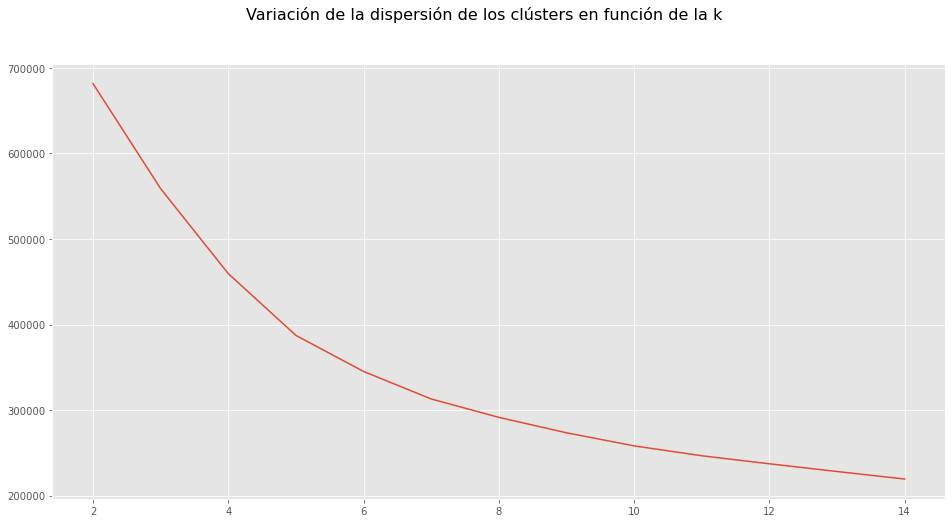

In [92]:
if CALCULATE_ELBOW:
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

<a id = "segmentacion"></a>
# 8.Segmentación de los clientes con la "k adecuada"
[Volver al índice](#table_of_contents)

Ahora que hemos determinado el número de centroides correcto podemos fittear nuestro pipeline con la ***k adecuada.***

Dado que vamos a realizar nuestra segmentación con KMeans y vamos a suministrarle las variables de nuestro interés, a veces, a KMeans se le conoce como **segmentación no supervisada pero guiada***. Guiada porque de alguna manera el data scientist le dice (lo guía) a que discrimine usando unas variables y no otras.

In [93]:
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()), 
    ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
    ("FeatureGenerator", FeatureGenerator()),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["amount", "max_delay"])),
    ("StandardScaler", StandardScaler()),
    ("Clustering", KMeans(n_clusters = 5))
])

In [94]:
df_final.shape

(99440, 8)

In [95]:
pipe.fit(df_final)

Pipeline(steps=[('Imputer', KNNImputer()),
                ('ArrayToDataFrame',
                 ArrayToDataFrame(columns=['max_pay', 'min_pay', 'mean_pay',
                                           'total_pay', 'max_seq',
                                           'time_since_last_purchase',
                                           'delivery_time', 'delay'],
                                  index=['861eff4711a542e4b93843c6dd7febb0',
                                         '290c77bc529b7ac935b93aa66c333dc3',
                                         '060e732b5b29e8181a18229c7b0b2b5e',
                                         '259dac757896d24d7702b9acbbff3f3c',
                                         '345ecd01c3...
                                         '5f102dd37243f152aec3607970aad100',
                                         '9c0096673baf55453a50073f12d1a37f',
                                         '2e6a42a9b5cbb0da62988694f18ee295',
                                        

Una parte muy interesante de los pipelines es que la podemos filtrar (igual que una lista de python) y usar sólo parte de los pasos que tenemos implementados. 

Esto viene muy útil porque en nuestro caso, cuando vamos a hacer el predict (asignar a cada cliente su centroide), queremos imputar los nulos, crear las variables necesarias y estandarizar (paso 1, 3 y 5 del pipe), pero **no filtrar los outliers** (todos los clientes tienen que tener un grupo). Si hacemos el predict con todo el pipeline, algunos clientes no se van a asignar a ningún grupo.

In [96]:
# creamos un dataframe escalado con los pasos 1-3 y 5
X_processed = pipe[:3].transform(df_final)
X_scaled = pipe["StandardScaler"].transform(X_processed)

# perdemos clientes por el paso 3: clientes con más de 1 pedido o pago, se acaba agrupando en 1 único registro.
X_scaled.shape

(96095, 9)

In [97]:
# hacemos el predict, en este caso tendremos para cada cliente su centroide/clúster.
labels = pipe["Clustering"].predict(X_scaled)

In [98]:
pipe["Clustering"]

KMeans(n_clusters=5)

In [99]:
# le asignamos al DataFrame procesado los centroides.
# SI LO HACEMOS AL ESCALADO LOS NÚMEROS PERDERAN SU SIGNIFICADO ESCALA Y SERÁN MÁS DÍFICILES DE INTERPRETAR.
X_processed["cluster"] = labels

In [100]:
X_processed.shape

(96095, 10)

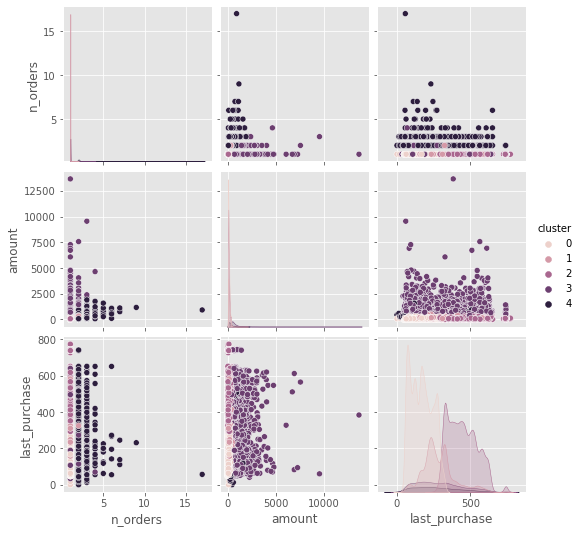

In [101]:
# visualizamos nuestros grupos en base a las variables del modelo RFM, para ver que tal han quedado.
selected_columns = ['n_orders', 'amount', 'last_purchase']

sns.pairplot(X_processed, vars = selected_columns, hue = 'cluster');

<a id = "rfm"></a>
# 9.Modelo RFM
[Volver al índice](#table_of_contents)

En esta sección vamos a ver como se puede implementar muy facilmente una segmentación basada en 3 indicadores claves de: ***retencia, frecuencia y valor monetario (RFM).***

De alguna manera, hasta ahora, hemos creado variables relacionadas con este modelo.

In [102]:
# calculamos los indicadores de RFM
QUANTILES = 5
X_processed['recency'] = pd.qcut(X_processed['last_purchase'], q = QUANTILES, labels = range(QUANTILES))
X_processed['frequency'] = (X_processed['n_orders'] > 1).astype(int)
X_processed['monetary_value'] = pd.qcut(X_processed['amount'], q = QUANTILES, labels = range(QUANTILES))

In [103]:
X_processed.pivot_table(index = 'recency', values = ['last_purchase'], aggfunc = [len, np.mean])

,len,mean
,last_purchase,last_purchase
recency,,
0,19324,94.166839
1,19299,185.444842
2,19043,270.176338
3,19300,366.464093
4,19129,524.501124


In [104]:
X_processed.pivot_table(index = 'monetary_value', values = ['amount'], aggfunc = [len, np.mean])

,len,mean
,amount,amount
monetary_value,,
0,19221,39.742998
1,19219,70.697066
2,19222,108.824944
3,19214,165.842255
4,19219,447.885889


In [105]:
X_processed.pivot_table(index = 'frequency', values = ['n_orders'], aggfunc = [len, np.mean])

,len,mean
,n_orders,n_orders
frequency,,
0,93098,1.000000
1,2997,2.116116


In [106]:
rm_df = pd.crosstab(X_processed['recency'], X_processed['monetary_value'])

In [107]:
rm_df

monetary_value,0,1,2,3,4
recency,,,,,
0,3842,3662,3883,3999,3938
1,3748,3653,3924,4061,3913
2,3951,3716,3789,3945,3642
3,3697,4147,3824,3724,3908
4,3983,4041,3802,3485,3818


<AxesSubplot:xlabel='monetary_value', ylabel='recency'>

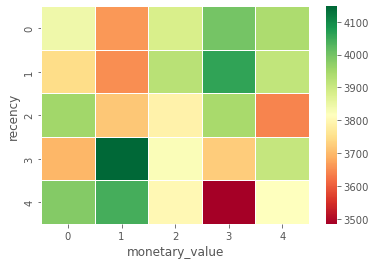

In [108]:
sns.heatmap(rm_df, cmap = 'RdYlGn', linewidths = 0.5)

In [109]:
X_processed[['recency', 'frequency', 'monetary_value', "n_orders"]].\
groupby(['recency', 'frequency', 'monetary_value']).agg('count')

n_orders
recency frequency monetary_value          
0       0         0                   3835
                  1                   3629
                  2                   3798
                  3                   3841
                  4                   3529
        1         0                      7
                  1                     33
                  2                     85
                  3                    158
                  4                    409
1       0         0                   3738
                  1                   3622
                  2                   3848
                  3                   3902
                  4                   3567
        1         0                     10
                  1                     31
                  2                     76
                  3                    159
                  4                    346
2       0         0                   3949
                  1                   3689
                  2                   3706
                  3                   3784
                  4                   3286
        1         0                      2
                  1                     27
                  2                     83
                  3                    161
                  4                    356
3       0         0                   3692
                  1                   4110
                  2                   3725
                  3                   3575
                  4                   3607
        1         0                      5
                  1                     37
                  2                     99
                  3                    149
                  4                    301
4       0         0                   3975
                  1                   4003
                  2                   3729
                  3                   3366
                  4                   3593
        1         0                      8
                  1                     38
                  2                     73
                  3                    119
                  4                    225

<a id = "ficha"></a>
# 10.Ficha de los clientes
[Volver al índice](#table_of_contents)

El último paso, usa vez que tenemos hecha nuestra segmentación completa es crear una ***ficha resumen*** de cada grupo con las principales variables de negocio o con aquellas que no se han utilizado en la segmentación para hacer un seguimiento periódico de los grupos o para enviar como documento al resto de los departamentos de la empresa.

In [110]:
ficha_df = pd.DataFrame()
ficha_df

""


In [111]:
for i, col in enumerate(["amount", "n_orders", "last_purchase", "mean_delay"]):
    resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)

In [112]:
resumen_data

cluster                  0           1           2          3          4
mean_delay mean -13.812394    0.490014  -15.043994 -13.566565 -12.928495
           std    7.281686   12.872841    7.056816   8.648294   6.877293
           min  -71.000000  -52.000000 -147.000000 -63.000000 -71.000000
           25%  -18.000000   -7.000000  -18.000000 -18.000000 -16.500000
           50%  -13.000000   -2.000000  -14.000000 -13.000000 -12.500000
           75%   -9.000000    4.000000  -10.200000  -8.400000  -9.000000
           max    7.000000  188.000000    5.000000  40.000000  15.666667

In [113]:
# generamos nuestro multiindex
out_index = [
    "Monetarios",
    "Fidelización",
    "Fidelización",
    "Logística"
]

inner_index = [
    "Importe",
    "Nr. de compras",
    "Última compra",
    "Retrasos"
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))
        
new_multi_index

[('Monetarios', 'Importe', 'Media'),
 ('Monetarios', 'Importe', 'Desviación'),
 ('Monetarios', 'Importe', 'Mínimo'),
 ('Monetarios', 'Importe', 'Perc. 25'),
 ('Monetarios', 'Importe', 'Perc. 50'),
 ('Monetarios', 'Importe', 'Perc. 75'),
 ('Monetarios', 'Importe', 'Máximo'),
 ('Fidelización', 'Nr. de compras', 'Media'),
 ('Fidelización', 'Nr. de compras', 'Desviación'),
 ('Fidelización', 'Nr. de compras', 'Mínimo'),
 ('Fidelización', 'Nr. de compras', 'Perc. 25'),
 ('Fidelización', 'Nr. de compras', 'Perc. 50'),
 ('Fidelización', 'Nr. de compras', 'Perc. 75'),
 ('Fidelización', 'Nr. de compras', 'Máximo'),
 ('Fidelización', 'Última compra', 'Media'),
 ('Fidelización', 'Última compra', 'Desviación'),
 ('Fidelización', 'Última compra', 'Mínimo'),
 ('Fidelización', 'Última compra', 'Perc. 25'),
 ('Fidelización', 'Última compra', 'Perc. 50'),
 ('Fidelización', 'Última compra', 'Perc. 75'),
 ('Fidelización', 'Última compra', 'Máximo'),
 ('Logística', 'Retrasos', 'Media'),
 ('Logística', 'Ret

In [114]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [115]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [116]:
tamaño_clusters = X_processed.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [117]:
ficha_df = tamaño_clusters.append(ficha_df)

In [118]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

<a id = "conclusión"></a>
# 11.Conclusión
[Volver al índice](#table_of_contents)

Los algoritmos no supervisados son herramientas **muy potentes** que cualquier data scientist debe tener a mano. Saber el funcionamiento y hacer la correcta implementación de estos, puede permitir **extraer información muy valiosa y tomar mejores decisiones de negocio**. Hemos visto diferentes algoritmos y técnicas no supervisadas (***KMeans y modelo RFM***) que nos permiten crear **grupos homogéneos y accionables** de clientes y así mejorar los indicadores de la compañia.

Además de esto, hemos aprendido a utilizar los pipelines de sklearn para **automatizar al máximo el tratamiento de datos** así como implementar nuestros propios ***Transformers*** que puede ser utilizados dentro del pipeline.